In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from typing_extensions import TypedDict
from typing import Literal
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import Image, display

In [ ]:
class AgentState(TypedDict):
    query: str # 사용자 질문
    answer: str # 세율
    tax_base_equation: str # 과세표준 계산 수식 
    tax_deduction: str # 공제액 
    market_ratio: str # 공정시장가액비율
    tax_base: str # 과세표준 계산

In [5]:
class Route(BaseModel):
    target: Literal['income_tax', 'real_estate_tax', 'basic_llm', 'web_search'] = Field(
        description="사용자 질문을 처리할 적절한 경로"
    )

In [6]:
router_system_prompt = """
당신은 세금 전문가 질문 라우터입니다.
사용자의 질문을 다음 중 어디로 보낼지 판단하세요:
- 'income_tax': 소득세 관련 질문
- 'real_estate_tax': 부동산세 관련 질문
- 'basic_llm': 단순 질의 (벡터 검색 필요 없음)
- 'web_search': 최신 정보 필요할 때
"""

router_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", router_system_prompt),
        ("human", "{query}")
    ]
)

router_llm = ChatOpenAI(model="gpt-4o-mini")
structured_router_llm = router_llm.with_structured_output(Route)

In [7]:
# ===== 라우터 함수 =====
def router(state: AgentState) -> Literal['income_tax', 'real_estate_tax', 'basic_llm', 'web_search']:
    query = state['query']
    route_chain = router_prompt | structured_router_llm
    route = route_chain.invoke({"query": query})
    print("선택된 경로:", route.target)
    return route.target


# ===== 노드 함수 정의 =====
def income_tax_agent(state: AgentState) -> AgentState:
    """소득세 관련 질문 처리"""
    state['answer'] = "소득세 계산 결과입니다."
    return state


def real_estate_tax_agent(state: AgentState) -> AgentState:
    """부동산세 관련 질문 처리"""
    state['answer'] = "부동산세 계산 결과입니다."
    return state


def basic_llm(state: AgentState) -> AgentState:
    """단순한 일반 질문 처리"""
    state['answer'] = "단순 질문에 대한 답변입니다."
    return state


def web_search(state: AgentState) -> AgentState:
    """
    웹 검색을 통해 주택 공시가격/공정시장가액비율 등 최신 정보를 가져옴
    node 함수로 동작하므로 state를 받지만, 내부적으로는 검색만 수행
    """
    state['market_ratio'] = "웹 검색을 통해 가져온 공정시장가액비율 예시값"
    return state


def web_generate(state: AgentState) -> AgentState:
    """웹 검색 결과를 바탕으로 최종 답변 생성"""
    state['answer'] = f"웹 검색 기반 최종 답변입니다. (시장비율: {state.get('market_ratio', '없음')})"
    return state

In [8]:
graph_builder = StateGraph(AgentState)

graph_builder.add_node("income_tax", income_tax_agent)
graph_builder.add_node("real_estate_tax", real_estate_tax_agent)
graph_builder.add_node("basic_llm", basic_llm)
graph_builder.add_node("web_search", web_search)
graph_builder.add_node("web_generate", web_generate)

In [9]:
# 조건부 라우팅
graph_builder.add_conditional_edges(
    START,
    router,
    {
        "income_tax": "income_tax",
        "real_estate_tax": "real_estate_tax",
        "basic_llm": "basic_llm",
        "web_search": "web_search",
    }
)

# 웹 검색 후 generate 연결
graph_builder.add_edge("web_search", "web_generate")

# 종료 지점 연결
graph_builder.add_edge("income_tax", END)
graph_builder.add_edge("real_estate_tax", END)
graph_builder.add_edge("basic_llm", END)
graph_builder.add_edge("web_generate", END)

# 그래프 완성
graph = graph_builder.compile()

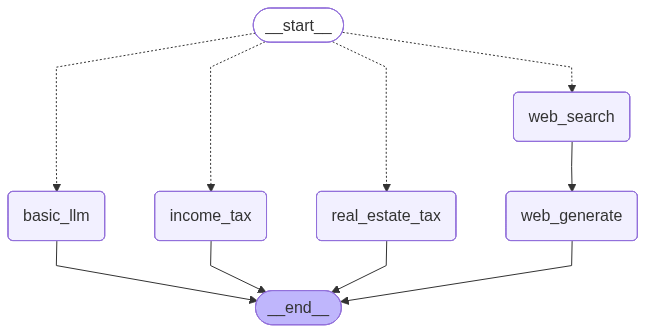

In [10]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
# 소득세 관련 질문
initial_state = {"query": "연봉 5000만원이면 소득세가 얼마야?"}
result = graph.invoke(initial_state)
print(result)


선택된 경로: income_tax
{'query': '연봉 5000만원이면 소득세가 얼마야?', 'answer': '소득세 계산 결과입니다.'}


In [13]:
#부동산세 관련 질문

initial_state = {"query": "서울에 아파트 2채 있을 때 부동산세가 얼마나 나와?"}
result = graph.invoke(initial_state)
print(result)


선택된 경로: real_estate_tax
{'query': '서울에 아파트 2채 있을 때 부동산세가 얼마나 나와?', 'answer': '부동산세 계산 결과입니다.'}


In [14]:
# 웹 서치 필요없는 단순 질문

initial_state = {"query": "대한민국 수도는 어디야?"}
result = graph.invoke(initial_state)
print(result)

선택된 경로: basic_llm
{'query': '대한민국 수도는 어디야?', 'answer': '단순 질문에 대한 답변입니다.'}


In [15]:
# 웹 서치 필요한 질문

initial_state = {"query": "올해 주택 공시가격 기준 공정시장가액비율 알려줘"}
result = graph.invoke(initial_state)
print(result)

선택된 경로: web_search
{'query': '올해 주택 공시가격 기준 공정시장가액비율 알려줘', 'answer': '웹 검색 기반 최종 답변입니다. (시장비율: 웹 검색을 통해 가져온 공정시장가액비율 예시값)', 'market_ratio': '웹 검색을 통해 가져온 공정시장가액비율 예시값'}
